In [1]:
!wget http://www.cs.cmu.edu/~jiweil/review.txt.zip

!wget http://www.cs.cmu.edu/~jiweil/offering.txt.zip

!unzip review.txt.zip
!unzip offering.txt.zip
!mkdir /content/data/
!mkdir /content/data/tripadvisor
!mv review.txt /content/data/tripadvisor/review.txt
!mv offering.txt /content/data/tripadvisor/offering.txt

--2024-12-15 17:14:34--  http://www.cs.cmu.edu/~jiweil/review.txt.zip
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373708772 (356M) [application/zip]
Saving to: ‘review.txt.zip’

review.txt.zip      100%[===================>] 356.40M  3.50MB/s    in 1m 50s  

2024-12-15 17:16:24 (3.24 MB/s) - ‘review.txt.zip’ saved [373708772/373708772]

--2024-12-15 17:16:24--  http://www.cs.cmu.edu/~jiweil/offering.txt.zip
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175694 (172K) [application/zip]
Saving to: ‘offering.txt.zip’

offering.txt.zip    100%[===================>] 171.58K  --.-KB/s    in 0.1s    

2024-12-15 17:16:24 (1.59 MB/s) - ‘offering.txt.zip’ saved [175694/175694]

Archive:  review.txt.zip
  inflating:

In [ ]:
!ls /content/data/tripadvisor

offering.txt  review.txt


In [ ]:
# Import necessary libraries
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('wordnet')

# Initialize tqdm for pandas
tqdm.pandas()

# Step 1: Load and Parse Data
# Note: Adjust the file path as needed
reviews = []
with open('/content/data/tripadvisor/review.txt', 'r', encoding='utf-8') as file:
    for line in tqdm(file, desc='Loading data'):
        data = json.loads(line)
        reviews.append(data)

df_reviews = pd.DataFrame(reviews)

# Normalize 'ratings' field
ratings_df = pd.json_normalize(df_reviews['ratings'])
df_reviews = pd.concat([df_reviews.drop('ratings', axis=1), ratings_df], axis=1)

# Convert 'offering_id' to string
df_reviews['offering_id'] = df_reviews['offering_id'].astype(str)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
Loading data: 878561it [00:26, 32899.66it/s]


# Identify the Top 50 Hotels

Loading data: 878561it [00:20, 43334.80it/s]
Analyzing Sentiment: 100%|██████████| 127670/127670 [02:49<00:00, 752.14it/s]
<ipython-input-2-b92c7dd81f20>:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mobility_reviews_per_hotel, x='offering_id', y='num_mobility_reviews', palette='Blues_d')


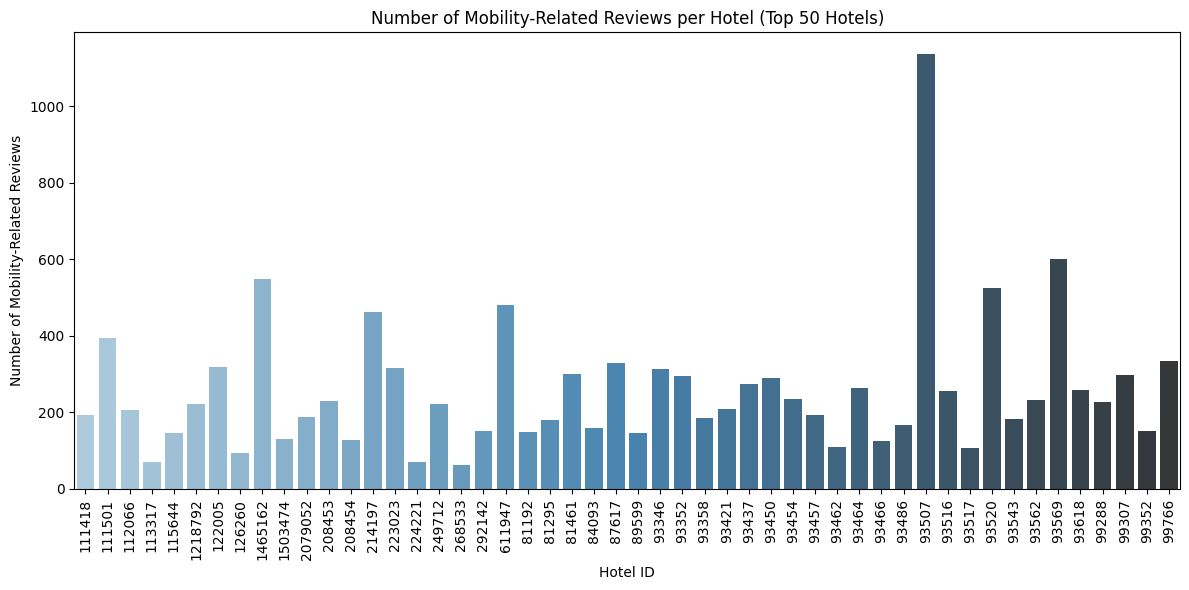

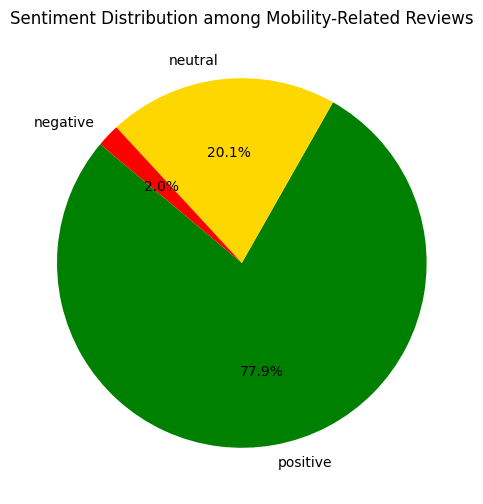

KeyError: 'text_processed'

In [2]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import spacy
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Initialize tqdm for pandas
tqdm.pandas()

# Step 1: Load and Parse Data
# Replace 'review.txt' with the path to your data file
reviews = []
with open('/content/data/tripadvisor/review.txt', 'r', encoding='utf-8') as file:
    for line in tqdm(file, desc='Loading data'):
        data = json.loads(line)
        reviews.append(data)

df_reviews = pd.DataFrame(reviews)

# Normalize 'ratings' field
ratings_df = pd.json_normalize(df_reviews['ratings'])
df_reviews = pd.concat([df_reviews.drop('ratings', axis=1), ratings_df], axis=1)

# Convert 'offering_id' to string
df_reviews['offering_id'] = df_reviews['offering_id'].astype(str)

# Step 2: Identify the Top 50 Hotels
# Calculate the number of reviews per hotel
reviews_per_hotel = df_reviews.groupby('offering_id').size().reset_index(name='num_reviews')

# Sort hotels by number of reviews in descending order
reviews_per_hotel_sorted = reviews_per_hotel.sort_values(by='num_reviews', ascending=False)

# Select the top 50 hotels
top_50_hotels = reviews_per_hotel_sorted.head(50)

# Get the list of hotel IDs
selected_hotels = top_50_hotels['offering_id'].tolist()

# Step 3: Filter Reviews for the Selected Hotels
df_selected = df_reviews[df_reviews['offering_id'].isin(selected_hotels)].copy()

# Step 4: Text Preprocessing using SpaCy
# Ensure 'text' column is in string format
df_selected['text'] = df_selected['text'].astype(str)

# Preprocessing function using SpaCy
def preprocess_text(text):
    # Lowercase and clean text
    cleaned_text = re.sub(r'[^a-z\s]', '', text.lower())
    # Process with SpaCy
    doc = nlp(cleaned_text)
    # Lemmatize tokens
    lemmatized_tokens = [token.lemma_ for token in doc]
    # Return preprocessed text
    return ' '.join(lemmatized_tokens)

# Apply preprocessing
tqdm.pandas(desc="Preprocessing Text")
df_selected['text_processed'] = df_selected['text'].progress_apply(preprocess_text)

# Step 5: Keyword Matching
# Define mobility-related keywords
mobility_keywords = [
    'wheelchair', 'wheel chair', 'accessible', 'elevator', 'lift', 'ramp',
    'disabled', 'disability', 'handicap', 'mobility', 'stairs', 'step-free',
    'barrier-free', 'ada', 'grab bars', 'shower chair', 'hearing impaired',
    'visual impaired', 'guide dog', 'service dog', 'accessible entrance',
    'mobility scooter', 'accessible pool', 'accessible toilet'
]

# Compile regex pattern
escaped_keywords = [re.escape(keyword) for keyword in mobility_keywords]
keyword_pattern = r'\b(' + '|'.join(escaped_keywords) + r')\b'
keyword_regex = re.compile(keyword_pattern, re.IGNORECASE)

# Function to flag mobility-related reviews
def keyword_flag(text):
    return bool(keyword_regex.search(text))

# Apply the function
tqdm.pandas(desc="Flagging Mobility-Related Reviews")
df_selected['mobility_related'] = df_selected['text_processed'].progress_apply(keyword_flag)

# Extract matched keywords
def extract_keywords(text):
    return keyword_regex.findall(text)

# Extract matched keywords
tqdm.pandas(desc="Extracting Mobility Keywords")
df_selected['mobility_keywords_found'] = df_selected['text_processed'].progress_apply(extract_keywords)

# Step 6: Sentiment Analysis
# Function to analyze sentiment
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis
tqdm.pandas(desc="Analyzing Sentiment")
df_selected['sentiment_score'] = df_selected['text'].progress_apply(analyze_sentiment)

# Classify sentiment
def classify_sentiment(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

df_selected['sentiment'] = df_selected['sentiment_score'].apply(classify_sentiment)

# Step 7: Compile the Final Dataset
final_columns = [
    'offering_id', 'title', 'text', 'mobility_related', 'mobility_keywords_found',
    'sentiment_score', 'sentiment', 'service', 'cleanliness', 'overall', 'value',
    'location', 'sleep_quality', 'rooms', 'date', 'date_stayed'
]

df_final = df_selected[final_columns].copy()

# Step 8: Visualize Results
# Sentiment Distribution
sentiment_counts = df_final[df_final['mobility_related']]['sentiment'].value_counts()

# Bar Chart: Mobility-Related Reviews per Hotel
mobility_reviews_per_hotel = df_final[df_final['mobility_related']].groupby('offering_id').size().reset_index(name='num_mobility_reviews')

plt.figure(figsize=(12, 6))
sns.barplot(data=mobility_reviews_per_hotel, x='offering_id', y='num_mobility_reviews', palette='Blues_d')
plt.xlabel('Hotel ID')
plt.ylabel('Number of Mobility-Related Reviews')
plt.title('Number of Mobility-Related Reviews per Hotel (Top 50 Hotels)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Pie Chart: Sentiment Distribution
plt.figure(figsize=(6, 6))
colors = ['green', 'gold', 'red']
sentiment_counts = sentiment_counts.reindex(['positive', 'neutral', 'negative'])
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Sentiment Distribution among Mobility-Related Reviews')
plt.ylabel('')
plt.show()

# Word Cloud: Common Words in Mobility-Related Reviews
mobility_text = ' '.join(df_final[df_final['mobility_related']]['text_processed'])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(mobility_text)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Mobility-Related Reviews')
plt.show()

# Step 9: Save Results
df_final.to_csv('mobility_reviews_analysis_top_50_hotels.csv', index=False)


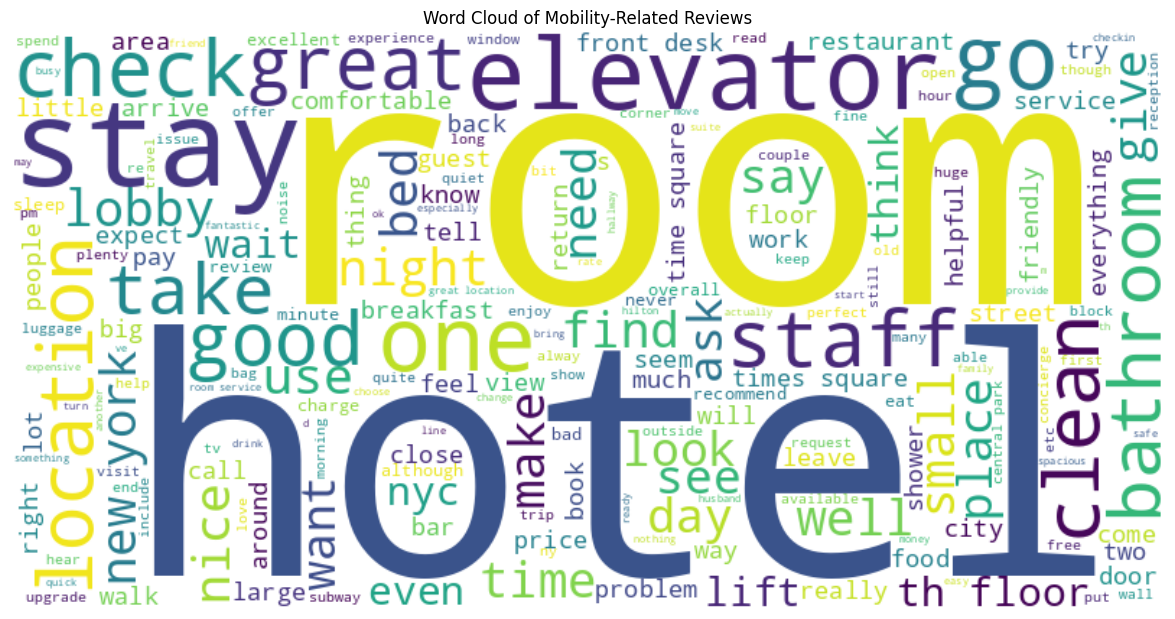

In [3]:
# Word Cloud: Common Words in Mobility-Related Reviews
#df_final = df_selected[final_columns].copy()
mobility_text = ' '.join(df_selected[df_selected['mobility_related']]['text_processed'])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(mobility_text)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Mobility-Related Reviews')
plt.show()

# Step 9: Save Results
df_selected.to_csv('mobility_reviews_analysis_top_50_hotels.csv', index=False)

# Adding more Keywords to capture more reviews

In [4]:
# Updated mobility-related keywords
mobility_keywords = [
    # Wheelchair variations
    'wheelchair', 'wheel chair', 'wheel-chair',
    # Accessibility
    'accessible', 'accessibility', 'accessible room', 'accessible bathroom', 'accessible shower',
    # Elevator and Lift
    'elevator', 'lift', 'escalator',
    # Ramps
    'ramp', 'ramps',
    # Disability terms
    'disabled', 'disability', 'handicap', 'handicapped', 'mobility', 'mobility issues', 'mobility impaired',
    # Stairs and Steps
    'stairs', 'steps', 'no stairs', 'step-free', 'step free', 'no steps',
    # Barrier-free
    'barrier-free', 'barrier free', 'no barriers',
    # ADA Compliance
    'ADA', 'ADA compliant', 'ADA room', 'ADA accessible',
    # Bathroom aids
    'bathroom rails', 'grab bars', 'shower chair', 'roll-in shower', 'roll in shower',
    # Visual and Hearing Impairments
    'braille', 'hearing impaired', 'hearing impairment', 'visual impaired', 'visual impairment', 'tactile signs',
    # Service animals
    'guide dog', 'service dog', 'assistance dog',
    # Parking
    'handicap parking', 'accessible parking', 'disabled parking',
    # Accessible facilities
    'accessible entrance', 'accessible facilities', 'accessible amenities',
    # Equipment
    'mobility scooter', 'wheelchair accessible', 'accessible path',
    # Additional terms
    'easy access', 'limited mobility', 'accessible pool', 'accessible toilet', 'accessible seating',
    # Misspellings and variations
    'wheelchiar', 'accesible', 'accsesible', 'elevater', 'handi-cap', 'accessable',
]

# Compile the regex pattern for keyword matching
escaped_keywords = [re.escape(keyword) for keyword in mobility_keywords]
keyword_pattern = r'\b(' + '|'.join(escaped_keywords) + r')\b'
keyword_regex = re.compile(keyword_pattern, re.IGNORECASE)


In [5]:
# Function to flag mobility-related reviews
def keyword_flag(text):
    return bool(keyword_regex.search(text))

# Apply the function to flag reviews
tqdm.pandas(desc="Flagging Mobility-Related Reviews")
df_selected['mobility_related'] = df_selected['text_processed'].progress_apply(keyword_flag)


Flagging Mobility-Related Reviews: 100%|██████████| 127670/127670 [00:51<00:00, 2464.51it/s]


In [6]:
# Function to extract matched keywords from text
def extract_keywords(text):
    return keyword_regex.findall(text)

# Apply the function to extract keywords
tqdm.pandas(desc="Extracting Mobility Keywords")
df_selected['mobility_keywords_found'] = df_selected['text_processed'].progress_apply(extract_keywords)


Extracting Mobility Keywords: 100%|██████████| 127670/127670 [00:58<00:00, 2191.87it/s]


<ipython-input-7-9758ea50c911>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=keyword_counts.head(20), x='count', y='keyword', palette='Blues_d')


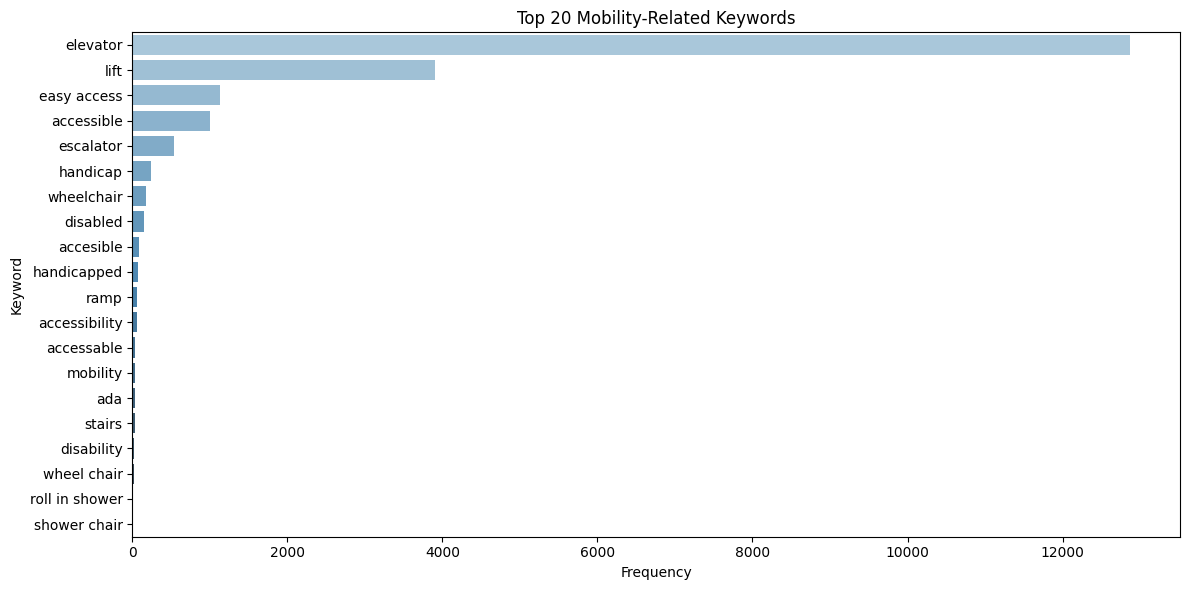

In [7]:
# Flatten the list of keywords for frequency analysis
all_keywords = [keyword for sublist in df_selected['mobility_keywords_found'] for keyword in sublist]

# Create a DataFrame of keyword frequencies
keyword_counts = pd.DataFrame(all_keywords, columns=['keyword']).value_counts().reset_index(name='count')
keyword_counts.columns = ['keyword', 'count']

# Plot the top 20 keywords
plt.figure(figsize=(12, 6))
sns.barplot(data=keyword_counts.head(20), x='count', y='keyword', palette='Blues_d')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.title('Top 20 Mobility-Related Keywords')
plt.tight_layout()
plt.show()


In [8]:
# Save the final dataset with mobility-related flags and keywords
df_selected.to_csv('mobility_reviews_with_keywords.csv', index=False)

# Save the keyword frequency analysis
keyword_counts.to_csv('mobility_keyword_frequencies.csv', index=False)


In [9]:
df_selected.shape

(127670, 23)

In [10]:
keyword_counts

,keyword,count
0,elevator,12872
1,lift,3910
2,easy access,1129
3,accessible,1000
4,escalator,539
5,handicap,245
6,wheelchair,171
7,disabled,144
8,accesible,80
9,handicapped,78


In [11]:
# Filter reviews containing mobility-related keywords
mobility_reviews = df_selected[df_selected['mobility_related']].copy()

# Save the filtered mobility-related reviews to a CSV file
mobility_reviews.to_csv('mobility_related_reviews.csv', index=False)

print(f"Saved {len(mobility_reviews)} mobility-related reviews to 'mobility_related_reviews.csv'")

Saved 14251 mobility-related reviews to 'mobility_related_reviews.csv'


In [12]:
import zipfile

# Define the CSV files to zip
csv_files = ['mobility_related_reviews.csv', 'mobility_keyword_frequencies.csv', 'mobility_reviews_with_keywords.csv']  # Add file names here

# Name of the zip file
zip_file_name = 'mobility_reviews.zip'

# Create a zip file and add the CSV files
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for file in csv_files:
        zipf.write(file)

print(f"Zipped files into '{zip_file_name}'")

Zipped files into 'mobility_reviews.zip'


In [ ]:
# Create github integration and push to https://github.com/voyageable/LLM-hackathon repository

# Push the code to Github
